In [1]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
import anndata            # core data structure for single-cell data (AnnData)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
from pertpy.tools import Distance  # distance metrics for single-cell data
import scvi               # single-cell variational inference (scVI) for deep learning
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch              # PyTorch (Tensor operations and GPU acceleration)
import pytorch_lightning as pl  # PyTorch Lightning (high-level training framework)

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.linear_model import LogisticRegression  # classifier used in metrics
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import (
    pairwise_distances,   # generic distance matrix
    silhouette_score,     # clustering quality
    roc_auc_score,        # AUROC for binary classification tasks
    r2_score              # R-squared for regression tasks
)

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import seaborn as sns            # higher-level statistical plots

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED, workers=True)
scvi.settings.seed = SEED 

print(f"Random seed set to {SEED}")

Seed set to 42
Seed set to 42


Random seed set to 42


In [2]:
adata = sc.read('data/kang_2018.h5ad') # loading the data directly from the file

adata.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )
    
sc.pp.filter_genes(adata, min_cells=3) # filtering genes expressed in at least 3 cells
sc.pp.normalize_total(adata, target_sum=1e4) # normalizing total counts per cell to 10,000
sc.pp.log1p(adata) # log-transforming the data (log1p = log(x + 1))
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, subset=True) # selecting the top 2000 highly variable genes

# Creating a training set by excluding 'stimulated' cells of the specified cell type (CD4 T cells in this case)
celltype_to_train = 'CD4 T cells'

# Filtering the AnnData object to create a training set
train_adata = adata[~(
    (adata.obs['cell_type'] == celltype_to_train) &
    (adata.obs['condition'] == 'stimulated')
)].copy()

# Device & run-time options
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")


# Helper functions
def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """
    Compute the L1 (Manhattan) distance between mean-variance KDEs.
    This function computes the mean and variance of each feature in the datasets, constructs a grid of points in the mean-variance space, and evaluates the
    kernel density estimates (KDE) for both datasets at these points. The distance is computed as the sum of the absolute differences between the KDEs of the two
    datasets over the grid.
    If either dataset has no valid points (e.g., all NaNs), the function returns NaN.
    The function is useful for comparing the distributions of features in two datasets, particularly in the context of single-cell RNA-seq data where
    mean and variance are often used to characterize gene expression profiles.
    """        
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1,v1]), np.column_stack([m2,v2])
    ok = ~(np.isnan(pts1).any(1)|np.isnan(pts2).any(1))
    pts1, pts2 = pts1[ok], pts2[ok]
    if pts1.size==0 or pts2.size==0:
        return np.nan
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1,2)
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum()*dx*dy)

def energy_distance(Xa, Xb):
    """
    This function computes the energy distance between two multivariate samples.
    The energy distance is a measure of the difference between two probability distributions, defined as:
    E(Xa, Xb) = 2 * mean(d(Xa, Xb)) - mean(d(Xa, Xa)) - mean(d(Xb, Xb))
    where d is the Euclidean distance.
    """
    a_b = cdist(Xa, Xb, metric="euclidean").mean()
    a_a = cdist(Xa, Xa, metric="euclidean").mean()
    b_b = cdist(Xb, Xb, metric="euclidean").mean()
    return 2 * a_b - a_a - b_b


def bootstrap_metrics(X, real_mask, pred_mask, pca, n_boot=100, frac=0.8, seed=SEED):
    """
    Bootstrap metrics for evaluating the performance of a model.
    This function computes the R2, MSE, and Pearson correlation coefficients between the predicted and real data.
    It uses bootstrapping to estimate the variability of these metrics.
    """
    rng = np.random.default_rng(seed)
    r_idx, p_idx = np.where(real_mask)[0], np.where(pred_mask)[0]
    if len(r_idx)==0 or len(p_idx)==0:
        return {k:np.nan for k in ['R2','MSE','Pearson']}
    s_r, s_p = int(frac*len(r_idx)), int(frac*len(p_idx))
    vals = {'R2':[], 'MSE':[], 'Pearson':[]}
    for _ in range(n_boot):
        r = rng.choice(r_idx, s_r, replace=True)
        p = rng.choice(p_idx, s_p, replace=True)
        Y, Xp = X[r].mean(0), X[p].mean(0)
        d = Xp - Y
        vals['MSE'].append(np.mean(d**2))
        ss_res = ((Y - Xp)**2).sum(); ss_tot = ((Y - Y.mean())**2).sum()
        vals['R2'].append(1-ss_res/ss_tot if ss_tot>0 else np.nan)
        vals['Pearson'].append(stats.pearsonr(Xp, Y)[0])
    return {k:np.nanmean(v) for k,v in vals.items()}

Running on CPU – no CUDA device


## 1. scGen Hyperparameter Optimization with Optuna

In [6]:
# ╔════════════════════════════════════════════════════════════════════╗
# ║  Mini-sweep: 4 scGen models (2×2 hyper-parameter grid)             ║
# ╚════════════════════════════════════════════════════════════════════╝
import itertools, time, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pertpy.tools import Distance
from sklearn.metrics import r2_score
from matplotlib.gridspec import GridSpec

# ---------------------------------------------------------------------
# 0) grid definition  ▸ 4 combinations
# ---------------------------------------------------------------------
latent_vals  = [8, 64]          # low vs high capacity
dropout_vals = [0.05, 0.30]     # light vs strong regularisation
grid = list(itertools.product(latent_vals, dropout_vals))

# ---------------------------------------------------------------------
# 1) container to collect metrics + PCs for plots
# ---------------------------------------------------------------------
results   = []
pca_snaps = []                  # (label, X_pca, obs_condition) for each run

start = time.time()
for n_latent, dropout in grid:
    label = f"n{n_latent}_do{dropout}"
    print(f"\n🔧 Training model {label}")

    # -- (a) hold-out IFN-β CD4-T cells -------------------------------
    train_adata = adata[~(
        (adata.obs["cell_type"] == "CD4 T cells") &
        (adata.obs["condition"] == "stimulated")
    )].copy()

    # HVGs keep the tutorial fast
    sc.pp.highly_variable_genes(train_adata, n_top_genes=2000,
                                flavor="seurat_v3", subset=True)

    # -- (b) set-up & train ------------------------------------------
    pt.tl.Scgen.setup_anndata(train_adata,
                              batch_key  ="condition",
                              labels_key ="cell_type")

    model = pt.tl.Scgen(
        train_adata,
        n_hidden    = 128,            # keep defaults to limit search space
        n_latent    = n_latent,
        n_layers    = 2,
        dropout_rate= dropout,
    )
    model.train(
        max_epochs     = 10,
        batch_size     = 32,
        early_stopping = True,
        accelerator    = ("gpu" if cuda_available else "cpu"),
        devices        = 1
    )

    # -- (c) prediction for held-out CD4-T ----------------------------
    pred, _ = model.predict("control", "stimulated",
                            celltype_to_predict="CD4 T cells")
    pred.obs["condition"] = "predicted"

    ctrl = adata[(adata.obs["cell_type"]=="CD4 T cells") &
                 (adata.obs["condition"]=="control")]
    stim = adata[(adata.obs["cell_type"]=="CD4 T cells") &
                 (adata.obs["condition"]=="stimulated")]

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()

    # quick PCA snapshot for later visual comparison
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
    pca_snaps.append((label, eval_ad.obsm["X_pca"],
                      eval_ad.obs["condition"].copy()))

    # -- (d) metrics --------------------------------------------------
    X       = eval_ad.X.A if sparse.issparse(eval_ad.X) else eval_ad.X
    stim_m  = eval_ad.obs["condition"] == "stimulated"
    pred_m  = eval_ad.obs["condition"] == "predicted"
    boot    = bootstrap_metrics(X, stim_m, pred_m, eval_ad.obsm["X_pca"])
    e_dist  = Distance("edistance").pairwise(
                  eval_ad[eval_ad.obs["condition"].isin(
                      ["stimulated","predicted"])],
                  groupby="condition"
              ).loc["predicted","stimulated"]
    mv_kde  = mean_var_kde_distance(X[stim_m], X[pred_m])

    sc.tl.rank_genes_groups(
        eval_ad, groupby="condition", reference="control",
        groups=["stimulated", "predicted"], method="wilcoxon",
        n_genes=eval_ad.n_vars
    )
    t100 = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
    p100 = eval_ad.uns["rank_genes_groups"]["names"]["predicted"][:100]
    jaccard = len(set(t100)&set(p100)) / (200 - len(set(t100)&set(p100)))

    results.append(dict(
        model       = label,
        R2          = boot["R2"],
        MSE         = boot["MSE"],
        Pearson     = boot["Pearson"],
        E_distance  = e_dist,
        MV_KDE      = mv_kde,
        Jaccard     = jaccard
    ))

print(f"\n✅  Finished {len(grid)} runs in {time.time()-start:.1f} s")

results_df = pd.DataFrame(results).set_index("model")
display(results_df.style.format("{:.3f}"))



🔧 Training model n8_do0.05
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/giatraskon/anaconda3/envs/MLiC

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Output()

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/pertpy/tools/_distances/_distances.py:532: ImplicitModificationWarning: Setting element `.obsp['X_pca_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd



🔧 Training model n8_do0.3
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Output()

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/pertpy/tools/_distances/_distances.py:532: ImplicitModificationWarning: Setting element `.obsp['X_pca_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)



🔧 Training model n64_do0.05
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Output()

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/pertpy/tools/_distances/_distances.py:532: ImplicitModificationWarning: Setting element `.obsp['X_pca_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd



🔧 Training model n64_do0.3
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


INFO     Received view of anndata, making copy.                                                                    


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Output()

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/pertpy/tools/_distances/_distances.py:532: ImplicitModificationWarning: Setting element `.obsp['X_pca_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(



✅  Finished 4 runs in 425.7 s


,R2,MSE,Pearson,E_distance,MV_KDE,Jaccard
model,,,,,,
n8_do0.05,0.961,0.003,0.983,1.724,0.028,0.020
n8_do0.3,0.906,0.008,0.953,4.306,0.031,0.026
n64_do0.05,0.947,0.005,0.974,1.933,0.027,0.000
n64_do0.3,0.910,0.008,0.956,4.174,0.030,0.020


/tmp/ipykernel_7157/674916838.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


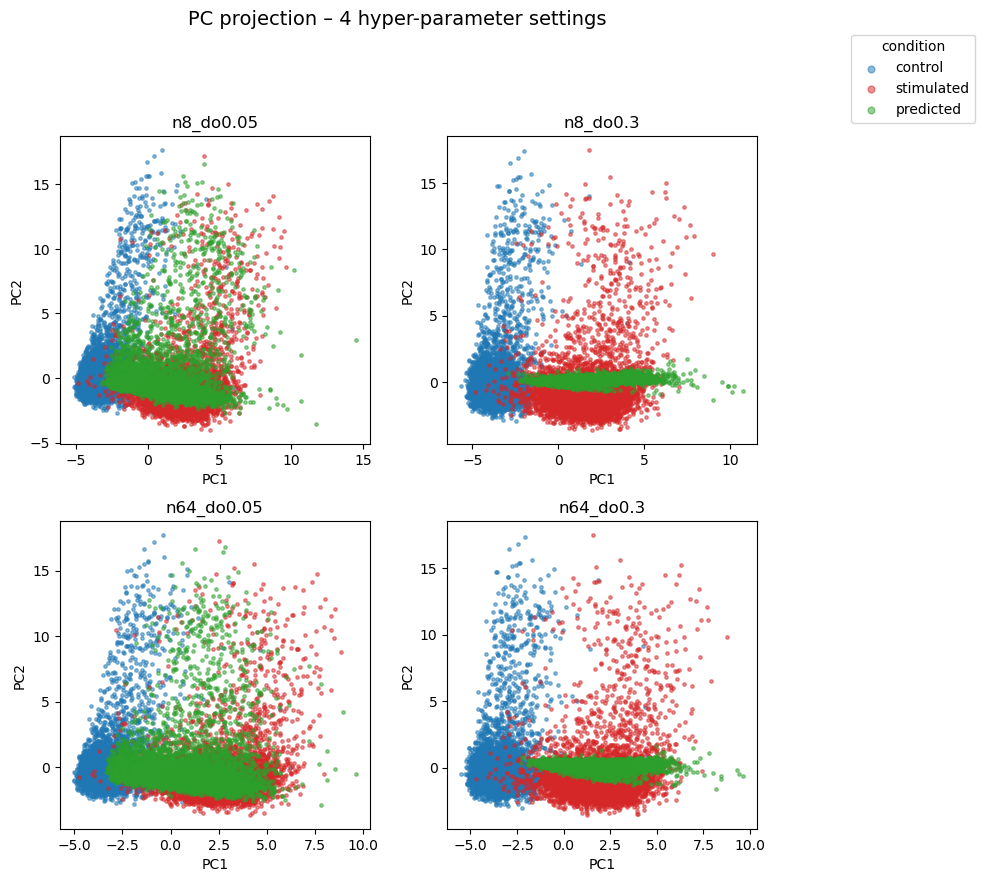

In [7]:
# ---------------------------------------------------------------------
# PCA scatter for each model
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(9, 9))
gs  = GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.25)

for ax, (label, X_pca, cond) in zip(fig.axes or
                                    [fig.add_subplot(gs[i,j])
                                     for i in range(2) for j in range(2)],
                                    pca_snaps):
    palette = {"control":"#1f77b4", "stimulated":"#d62728", "predicted":"#2ca02c"}
    for c in ["control", "stimulated", "predicted"]:
        m = cond == c
        ax.scatter(X_pca[m,0], X_pca[m,1], s=6, alpha=0.5,
                   label=c if ax is fig.axes[0] else "", c=palette[c])
    ax.set_title(label); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

fig.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0),
           title="condition", markerscale=2)
fig.suptitle("PC projection – 4 hyper-parameter settings", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()


/tmp/ipykernel_7157/1138349623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[m], ax=ax,
/tmp/ipykernel_7157/1138349623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[m], ax=ax,
/tmp/ipykernel_7157/1138349623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df[m], ax=ax,
/tmp/ipykernel_7157/1138349623.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable 

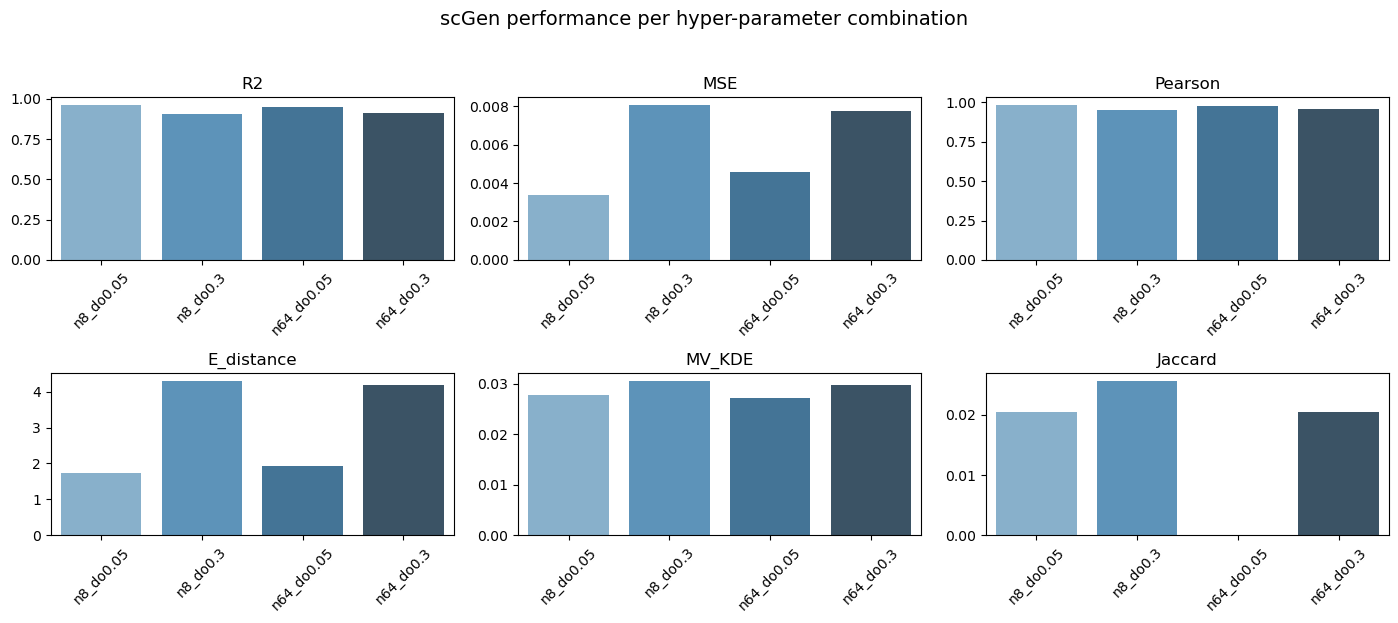

In [8]:
# ---------------------------------------------------------------------
# 6 metrics × 4 models
# ---------------------------------------------------------------------
metrics = ["R2", "MSE", "Pearson", "E_distance", "MV_KDE", "Jaccard"]
fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.ravel()

for ax, m in zip(axes, metrics):
    sns.barplot(x=results_df.index, y=results_df[m], ax=ax,
                palette="Blues_d", width=0.8)
    ax.set_title(m); ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("scGen performance per hyper-parameter combination",
             y=1.03, fontsize=14)
plt.tight_layout(); plt.show()


---

## 2. scGen Hyperparameter Testing Zone

In [3]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  ❶  Hyper-parameter playground – change values, hit ▶️        ║ 
# ╚════════════════════════════════════════════════════════════════╝
# NOTE: keep them within the suggested ranges to finish < 2–3 min.

# ── Architecture ────────────────────────────────────────────────
n_latent      = 32        #  [8 – 128]  latent-space dim
n_hidden      = 256       #  [64 – 512] neurons per hidden layer
n_layers      = 2         #  [1 – 3]    encoder / decoder depth
dropout_rate  = 0.10      #  [0.05 – 0.4]  regularisation

# ── Loss weighting & optimiser ──────────────────────────────────
lr            = 1e-3      #  [1e-4 – 3e-3] learning-rate (Adam)
weight_decay  = 1e-5      #  [1e-6 – 1e-3] L2 penalty

# ── Training loop ───────────────────────────────────────────────
batch_size    = 64        #  {32, 64, 128}  trade-off speed vs mem
max_epochs    = 15        #  (10–30)   >15 brings diminishing returns here

print("Custom hyper-parameters loaded ✅ – hit ▶️ on the next cell to train.")


Custom hyper-parameters loaded ✅ – hit ▶️ on the next cell to train.


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Training scGen…  (this should finish in ≲ 2 min on CPU)
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training:   0%|          | 0/15 [00:00<?, ?it/s]

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:368: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
`Trainer.fit` stopped: `max_epochs=15` reached.


INFO     Received view of anndata, making copy.                                                                    


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


✓ finished in 99.9 s


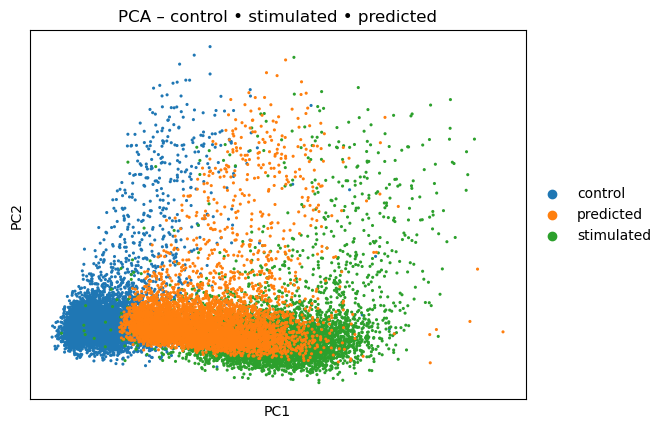

Output()

/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/pertpy/tools/_distances/_distances.py:532: ImplicitModificationWarning: Setting element `.obsp['X_pca_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd


/home/giatraskon/anaconda3/envs/MLiCB/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


,R2,MSE,Pearson,E_distance,MV_KDE,Jaccard
0,0.943,0.005,0.975,2.025,0.028,0.087


Output()

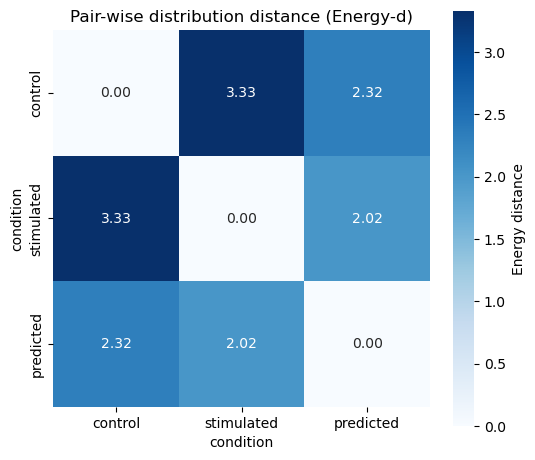

In [4]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║  ❷  Train scGen with *your* hyper-parameters & evaluate       ║
# ╚═══════════════════════════════════════════════════════════════╝
import time, sparse as sp, seaborn as sns, matplotlib.pyplot as plt
from pertpy.tools import Distance

t0 = time.time()
print("Training scGen…  (this should finish in ≲ 2 min on CPU)")

# 1) prepare training set – hide IFN-β CD4-T cells
celltype_to_train = "CD4 T cells"
train_adata = adata[~(
    (adata.obs["cell_type"] == celltype_to_train) &
    (adata.obs["condition"] == "stimulated")
)].copy()

# optional HVG pruning (kept at 2 000 for speed)
sc.pp.highly_variable_genes(train_adata, n_top_genes=2000,
                            flavor="seurat_v3", subset=True)

# 2) scGen setup & training
pt.tl.Scgen.setup_anndata(train_adata, batch_key="condition", labels_key="cell_type")
model = pt.tl.Scgen(
    train_adata,
    n_hidden=n_hidden,
    n_latent=n_latent,
    n_layers=n_layers,
    dropout_rate=dropout_rate,
)
model.train(
    max_epochs=max_epochs,
    batch_size=batch_size,
    early_stopping=True,
    plan_kwargs={"lr": lr, "weight_decay": weight_decay},
    devices=1, accelerator=("gpu" if torch.cuda.is_available() else "cpu"),
    logger=False, enable_checkpointing=False
)

# 3) make prediction
pred, _ = model.predict("control", "stimulated", celltype_to_predict=celltype_to_train)
pred.obs["condition"] = "predicted"

# 4) evaluation AnnData
ctrl = adata[(adata.obs["cell_type"]==celltype_to_train)&(adata.obs["condition"]=="control")]
stim = adata[(adata.obs["cell_type"]==celltype_to_train)&(adata.obs["condition"]=="stimulated")]
eval_ad = anndata.concat([ctrl, stim, pred]); eval_ad.obs_names_make_unique()
sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")   # needed for some metrics

print(f"✓ finished in {time.time()-t0:,.1f} s")

# 5) quick PCA visual
sc.pl.pca(eval_ad, color="condition", size=20, title="PCA – control • stimulated • predicted")

# 6) metrics
X = eval_ad.X.A if sparse.issparse(eval_ad.X) else eval_ad.X
stim_m = eval_ad.obs["condition"]=="stimulated"
pred_m = eval_ad.obs["condition"]=="predicted"

boot   = bootstrap_metrics(X, stim_m, pred_m, eval_ad.obsm["X_pca"])
e_dist = Distance("edistance").pairwise(
            eval_ad[eval_ad.obs["condition"].isin(["stimulated","predicted"])],
            groupby="condition"
         ).loc["predicted","stimulated"]
mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

sc.tl.rank_genes_groups(eval_ad, groupby="condition", reference="control",
                        groups=["stimulated","predicted"], method="wilcoxon",
                        n_genes=eval_ad.n_vars)
t100 = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
p100 = eval_ad.uns["rank_genes_groups"]["names"]["predicted"][:100]
jaccard = len(set(t100)&set(p100)) / (200-len(set(t100)&set(p100)))

import pandas as pd, numpy as np
res = pd.DataFrame([{
    "R2": boot["R2"], "MSE": boot["MSE"], "Pearson": boot["Pearson"],
    "E_distance": e_dist, "MV_KDE": mv_kde, "Jaccard": jaccard
}])
display(res.style.format("{:.3f}").set_caption("Performance metrics"))

# 7) Energy-distance heatmap
dist = Distance("edistance")
E_df = dist.pairwise(eval_ad, groupby="condition").loc[
    ["control","stimulated","predicted"], ["control","stimulated","predicted"]
]
plt.figure(figsize=(5.5,4.8))
sns.heatmap(E_df, annot=True, fmt=".2f", cmap="Blues", square=True,
            cbar_kws={"label":"Energy distance"})
plt.title("Pair-wise distribution distance (Energy-d)")
plt.tight_layout()
plt.show()
